In [1]:
"""The purpose of this script is to take standardized excel sheets generated from another software, analyze, and classify
the data into one of two cateogories.  Cell morphologies are recontructed in Neuroleucida Explorer, for this classification I am interested 
in the single, continuous, apical dendritic tree. 
Tracing software returns excel sheets for each cell's apical dendrite, where each branch point is identified as a node, and 
given a unique address(R - is the first node in the tree, giving rise to subnodes R1 and R2, R1 may then have R11 and R12 further subnodes)

Users should be careful of two potential pitfalls when using this program- 
(1) tracing should be as continuous as possible, and the
apical dendrite needs to be saved and exported properly from the Neuroleucida explorer - this analysis does not work on basal dend
trees or other non-pyramidal cell types. Poor cell recoveries, will tend to classify as simple! 
(2) Set the neuroleducida node labelling style to "Shaft" as opposed to centrifugal. Also note 
when tracing, any one branch point should have two daughter branches (NOT MORE).

This script was used in D'Amour et al., @ eLife, Aberrant sorting of hippocampal complex pyramidal cells in Type I Lissencephaly alters topological innervation """

import os
import math
import numpy as np
import pandas as pd
import re
import glob
import xlsxwriter

In [5]:
#This makes a place to store the list of geotypes for each experiment to be analyzed.
#Loops through and pulls the genotype information from each sheet

cellular_genotype = []

for f in morph_handles:
    gh = pd.read_excel(f, sheetname = 'Neuron Summary')
    gen = gh.iloc[8,0]
    cellular_genotype.append(gen)

In [7]:
#Making a function to perform the ORI calculation, LRI requires length knowledge and is implemented
#in the larger loop calculation below

def ORI_array(x, y):
    '''Perform the ORI calculation for all counted nodes, return values'''
    subbranch_node_order_ratio = x.truediv(y)
    subbranch_node_order_sum = x + y
    TT = subbranch_node_order_ratio.rmul(subbranch_node_order_sum)
    nodes_scaled = TT * 0.1
    results = np.log(nodes_scaled)
    return results

In [ ]:
ORI_max = []  #Open the ORI_max list, this is where the largest ORI node value is stored for each cell processed, 
            #these values are ultimately used to classify the cell
LRI_max = []

maxLRI_nodedists = []

maxORI_nodedists = []

ORI_mod_list = []
LRI_mod_list = []

for file_handle in morph_handles:  #Outer for loop - this will go through the list of compiled excel file handles, opening each for processing in the sub-loops
    df = pd.read_excel(file_handle, sheetname='Node-Apical Dendrite')  #there are multiple sheets, relevant data is on Node-Apical sheet
    nodes = df['Node']  #Assign the node column in the excel sheet to nodes
    node_dists = df['Distance Along Process (µm)']  #Assign the node distances column in the excel sheet to nodes_dists
    
    cleaned_nodes = []  #for each cell, remove the garbage characters, namely '-' and place it in 'cleaned_nodes'
    
    i=0
    for n in nodes:
        j = nodes[i].replace('-','')
        cleaned_nodes.append(j)
        i +=1

    cleaned_node_lens = []  # Makes a new list for the length of each node address (which is equivalent to its NODE ORDER!)
    ip = 0
    for p in cleaned_nodes:   #This nested-loop goes through the cleaned nodes  list and generates a list of their lengths in _lens
        k = len(cleaned_nodes[ip])
        cleaned_node_lens.append(k) 
        ip+=1

    node_df = pd.DataFrame()  #Creating a new dataframe and placing the cleaned nodes, their lengths, and dists in cols 1 2 and 3(below)
    node_df['col1'] = cleaned_nodes
    node_df['col2'] = cleaned_node_lens
    node_df['col3'] = node_dists
    node_df['col4'] = [0] * len(node_dists)
    node_df.columns = ['cleaned_nodes', 'cleaned_node_lens', 'node_dists', 'corr_nod_dist']  #titling the columns

    #How many nodes are there in the current cell = node_count
    node_count = len(cleaned_nodes)  

    subnodsA_df = pd.DataFrame(index = range(0,node_count,1), columns = [cleaned_nodes])  #opening 2 new dataframes to store lists of nodes, that correspond to subbranches for each simulated calulation
    subnodsB_df = pd.DataFrame(index = range(0,node_count,1), columns = [cleaned_nodes])  # corresponding columns in each DF represent the 2 different subbranches being compared in the ORI calculation

    
    # Now I fill the subnods_A and _B dataframe in this for loop, first I include a screening condition with an if statement
    a = 0
    for current_nod in cleaned_nodes:  
        #Node sorting into subbranches
        if len(node_df[node_df['cleaned_nodes'].str.contains(current_nod+'2')]) ==0: #Essentially, if each sub_branch from the current node does not have FURTHER subnodes, skip it
            a += 1
            continue
        elif len(node_df[node_df['cleaned_nodes'].str.contains(current_nod+'1')]) ==0:
            a += 1
            continue
        else:
         #Now when further subnodes exists, create a list of all the sub_sequent nodes in each branch
            sub_2flt = node_df['cleaned_nodes'].str.contains(current_nod+'2')
            sub_1flt = node_df['cleaned_nodes'].str.contains(current_nod+'1')
            temp1_vls = (node_df[['cleaned_nodes']][sub_1flt])
            temp2_vls = (node_df[['cleaned_nodes']][sub_2flt])
            temp1_len = len(temp1_vls)
            temp2_len = len(temp2_vls)
            if temp1_len >= temp2_len: #CRUCIAL to the calculation!  You must take the longer branch and store it subnodsB_df- DIVISION
                subnodsA_df[current_nod] = temp2_vls 
                subnodsB_df[current_nod] = temp1_vls
            else:
                subnodsA_df[current_nod] = temp1_vls 
                subnodsB_df[current_nod] = temp2_vls
            a += 1
    
    
    #ORI implementation: This snippet below uses count method on the coulmns of the seperated sub-node dataframes, these counts are equal to the node order!
    subA_node_counts = subnodsA_df.count(axis=0)
    subB_node_counts = subnodsB_df.count(axis=0)
       
    ORI = ORI_array(subA_node_counts, subB_node_counts)
    
    
    #Here we are fixing the node lengths and adding them back as a new column in the DF, then the LRI calculator will use this column
    corr_nod_dist = []

    for x in range(len(node_df.index)):
        nod_name = node_df['cleaned_nodes'].iloc[x]
        raw_nod_dist = node_df['node_dists'].iloc[x]
        prior_nod_name = nod_name[: -1]
        prior_nod_row = node_df[node_df['cleaned_nodes'] == prior_nod_name]
        prior_nod_dist = prior_nod_row['node_dists']
        held = raw_nod_dist - prior_nod_dist
        corr_nod_dist.append(held.values)
    
    node_df['corr_nod_dist'] = corr_nod_dist
    node_df['corr_nod_dist'] = node_df['corr_nod_dist'].str[0]
    
    
    #***LRI calculator**** Similar to ORI, but using distance between node points.
    
    current_cell_LRIarray = []
    
    lri_counter = 0
    for column in subnodsB_df:
        tempya = subnodsA_df.iloc[:, lri_counter].dropna()
        tempyb = subnodsB_df.iloc[:, lri_counter].dropna()
        La = node_df.loc[node_df['cleaned_nodes'].isin(tempya)]
        LA = La['corr_nod_dist']
        Lb = node_df.loc[node_df['cleaned_nodes'].isin(tempyb)]
        LB = Lb['corr_nod_dist']
            
        LA_sum = LA.sum()
        LB_sum = LB.sum()
        if LA_sum == 0:
            current_cell_LRIarray.append(-10)
            lri_counter += 1
            continue
        else:
            subbranch_len_sum = LA_sum + LB_sum
            subbranch_len_ratio = LA_sum/LB_sum
            node_LRI = np.log(0.004 * subbranch_len_sum * subbranch_len_ratio)
            current_cell_LRIarray.append(node_LRI)
            lri_counter += 1
        
    c = max(current_cell_LRIarray)
    
    #Extracting the distances of max_LRI_nodes - this is where the algo has a custom tweek - if the maximally-branching nodes are
    # >300 um from the soma, they are highly unlikely to be complex cells - so we decrement node scores for these cases.
    if max(current_cell_LRIarray) != -10:   
        c_index = current_cell_LRIarray.index(max(current_cell_LRIarray))
        max_LRI_node_dist = node_df.iloc[c_index, 2]
        maxLRI_nodedists.append(max_LRI_node_dist)
        
        if max_LRI_node_dist >=300:
            LRI_mod = (((max_LRI_node_dist - 299.9)/10)*0.04)
            rt = c - LRI_mod
            
            LRI_max.append(rt)
            LRI_mod_list.append(LRI_mod)
        else:
            LRI_max.append(c)
            LRI_mod_list.append(0)
    else:
        maxLRI_nodedists.append(-10)
        LRI_max.append(-10)
    
    b = ORI.max()
    
    if math.isnan(b) == False:
        b_index = ORI[ORI==b].index[0]
        max_ORI_node_dist = node_df.loc[node_df['cleaned_nodes'] == b_index, 'node_dists'].item()
        maxORI_nodedists.append(max_ORI_node_dist)
        
        if max_ORI_node_dist > 300:
            ORI_mod = (((max_ORI_node_dist - 299.9)/10)*0.04)
            et = b - ORI_mod
            ORI_max.append(et)
            ORI_mod_list.append(ORI_mod)
        
        else:
            ORI_max.append(b)
            ORI_mod_list.append(0)
            
    elif math.isnan(b)== True:
        ORI_max.append(-10)
        maxORI_nodedists.append(-10)    

In [ ]:
ORImax_mastersheet = pd.DataFrame({'Cell': morph_handles, 'Max ORI': ORI_max, 'Max LRI': LRI_max, 'Genotype': cellular_genotype, 'Symm_node_dist' : maxLRI_nodedists})
ORImax_mastersheet[ORImax_mastersheet == -10] = np.nan

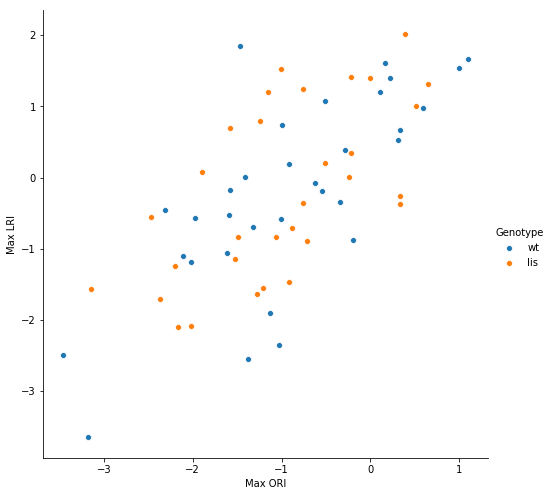

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, show

ORIvsLRI = sns.pairplot(x_vars=['Max ORI'], y_vars=['Max LRI'], data = ORImax_mastersheet, hue='Genotype', height=7)

plt.show()

In [14]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import plotly.plotly as py

In [ ]:
ORImax_mastersheet_inf = ORImax_mastersheet.replace([np.inf, -np.inf], np.nan)

wt_RIs = ORImax_mastersheet_inf[ORImax_mastersheet['Genotype'] == 'wt']
lis_RIs = ORImax_mastersheet_inf[ORImax_mastersheet['Genotype'] == 'lis']

In [42]:
import bokeh.plotting as bp
from bokeh.plotting import figure
from bokeh.io import export_png
from bokeh.io import export_svgs

bp.output_notebook()

Loading BokehJS ...

In [19]:
#Setting cluster number
wt_cluster = KMeans(n_clusters=2)
lis_cluster = KMeans(n_clusters=2)

In [20]:
#Doing the fits on the Wt and Lis data sets seperately.
wt_cluster.fit(wt_RIs_nand[wt_RIs_nand.columns[2:4]])
lis_cluster.fit(lis_RIs_nand[lis_RIs_nand.columns[2:4]])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [21]:
wt_cluster_list = wt_cluster.fit_predict(wt_RIs_nand[wt_RIs_nand.columns[2:4]])
lis_cluster_list = lis_cluster.fit_predict(lis_RIs_nand[lis_RIs_nand.columns[2:4]])

In [22]:
#Reassembling the datadrafmes with cluster assigned labels in a new column.

wt_cluster_df = pd.DataFrame(wt_cluster_list)
wt_cluster_df.index = wt_RIs_nand.index
wt_RIs_nand = wt_RIs_nand.join(wt_cluster_df, how='outer')
wt_RIs_nand.columns.values[5] = 'Clusters'

lis_cluster_df = pd.DataFrame(lis_cluster_list)
lis_cluster_df.index = lis_RIs_nand.index
lis_RIs_nand = lis_RIs_nand.join(lis_cluster_df, how='outer')
lis_RIs_nand.columns.values[5] = 'Clusters'

In [44]:
plot = figure(plot_width=500, plot_height=500, title='Kmeans Clustering of Apical Dendritic Morphology', x_axis_label='Max ORI', y_axis_label = 'Max LRI', toolbar_location = 'right', tools='box_zoom, wheel_zoom, pan, reset,hover')
wt_clus_xs = []
wt_clus_ys = []

lis_clus_xs = []
lis_clus_ys = []

p1 = plot.circle(wt_RIs_nand[wt_RIs_nand.Clusters==1]['Max ORI'],  wt_RIs_nand[wt_RIs_nand.Clusters==1]['Max LRI'], legend='Wt Complex', size=20, line_color='red', line_width=2, fill_color='red', alpha=0.5)
p2 = plot.circle(lis_RIs_nand[lis_RIs_nand.Clusters==0]['Max ORI'],  lis_RIs_nand[lis_RIs_nand.Clusters==0]['Max LRI'], legend='Lis Complex', size=20, line_color='navy', line_width=2, fill_color='navy', alpha=0.5)
p3 = plot.circle(wt_RIs_nand[wt_RIs_nand.Clusters==0]['Max ORI'],  wt_RIs_nand[wt_RIs_nand.Clusters==0]['Max LRI'], legend='Wt Simple', size=20, line_color='red', line_width=2, fill_color='white', alpha=0.5)
p4 = plot.circle(lis_RIs_nand[lis_RIs_nand.Clusters==1]['Max ORI'],  lis_RIs_nand[lis_RIs_nand.Clusters==1]['Max LRI'], legend='Lis Simple', size=20, line_color='navy', line_width=2, fill_color='white', alpha=0.5)

for entry in wt_cluster.cluster_centers_:
    wt_clus_xs.append(entry[1])
    wt_clus_ys.append(entry[0])

plot.circle_cross(x=wt_clus_xs, y=wt_clus_ys, size=20, fill_alpha=0, line_width=2, line_color='red')
#plot.text(text = ['Wt_S', 'Wt_C'], x=wt_clus_xs, y=wt_clus_ys, text_font_size='10pt')
i = 0

for entry in lis_cluster.cluster_centers_:
    lis_clus_xs.append(entry[1])
    lis_clus_ys.append(entry[0])

plot.circle_cross(x=lis_clus_xs, y=lis_clus_ys, size=20, fill_alpha=0, line_width=2, line_color='navy')
#plot.text(text = ['Ls_C', 'Ls_S'], x=lis_clus_xs, y=lis_clus_ys, text_font_size='10pt')
i = 0

plot.legend.location = 'bottom_right'
plot.legend.label_text_font = "times"
plot.legend.label_text_font_style = "italic"

bp.show(plot)